In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import neighbors
from sklearn.svm import SVR
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import plotly.express as px

In [63]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute distance between two pairs of (lat, lng)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

In [64]:
customers = pd.read_csv('csv normalizados\csv normalizados\CustomersNor.csv')
geolocation =  pd.read_csv('csv normalizados\csv normalizados\GeolocationNor.csv')
order_items =  pd.read_csv('csv normalizados\csv normalizados\Order_itemsNor.csv')
orders =  pd.read_csv('csv normalizados\csv normalizados\OrdersNor.csv')
products = pd.read_csv('csv normalizados\csv normalizados\ProductsNor.csv')
sellers = pd.read_csv('csv normalizados\csv normalizados\SellersNor.csv')

In [65]:
np.deg2rad(geolocation.geolocation_lat)

0         -0.410949
1         -0.410957
2         -0.410957
3         -0.410927
4         -0.410878
             ...   
1000158   -0.489890
1000159   -0.486548
1000160   -0.489946
1000161   -0.495480
1000162   -0.489916
Name: geolocation_lat, Length: 1000163, dtype: float64

In [66]:
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp order_approved_at  \
0    delivered               2017-10-02        2017-10-02   
1    delivered               2018-07-24        2018-07-26   
2    delivered               2018-08-08        2018-08-08   
3    delivered               2017-11-18        2017-11-18   
4    delivered               2018-02-13        2018-02-13   

  order_delivered_carrier_date order_delivered_customer_date  \
0                   2017-10-04                    2017-10-10   
1                   2018-07-26                    2018-08-07   
2                   2018-08-08                    2018-08-17   
3                   2017-11-22                    2017-12-02   
4                   2018-02-14                    2018-02-16   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

In [67]:
orders[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date',]]=orders[['order_purchase_timestamp',
       'order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

In [68]:
oneday = pd.Timedelta(days=1)

orders['time_delay'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']) / oneday

In [69]:
orders['est_to_deliver'] = np.where(orders['time_delay']<0, 1, 0)

In [70]:
orders.groupby('order_status').count()

order_id  customer_id  order_purchase_timestamp  \
order_status                                                    
approved             2            2                         2   
canceled           625          625                       625   
created              5            5                         5   
delivered        96478        96478                     96478   
invoiced           314          314                       314   
processing         301          301                       301   
shipped           1107         1107                      1107   
unavailable        609          609                       609   

              order_approved_at  order_delivered_carrier_date  \
order_status                                                    
approved                      2                             0   
canceled                    484                            75   
created                       0                             0   
delivered                 96464                         96476   
invoiced                    314                             0   
processing                  301                             0   
shipped                    1107                          1107   
unavailable                 609                             0   

              order_delivered_customer_date  order_estimated_delivery_date  \
order_status                                                                 
approved                                  0                              2   
canceled                                  6                            625   
created                                   0                              5   
delivered                             96470                          96478   
invoiced                                  0                            314   
processing                                0                            301   
shipped                                   0                           1107   
unavailable                               0                            609   

              time_delay  est_to_deliver  
order_status                              
approved               0               2  
canceled               6             625  
created                0               5  
delivered          96470           96478  
invoiced               0             314  
processing             0             301  
shipped                0            1107  
unavailable            0             609

In [71]:
order_items = pd.merge(order_items, sellers[['seller_id', 'seller_zip_code_prefix']], left_on='seller_id', right_on='seller_id').drop(['order_item_id','shipping_limit_date'], axis=1)
order_items

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       0188777fe321843a18be24a6e9aa1e53  436c8d57ff8d4aa254318e9bd9b48c83   
2       0191bbb5166d4b9a68df11797d5acfa9  ec02a5d380128f7a188e9ce8f3ddd832   
3       03054d8a8eefc2981cfad06f58e27979  3e31fd1419cc4cd6adad1925e72e3a03   
4       0c325ea6925de749e1420be0cf43587c  3a135477bf41350a0b1d8afdf616d446   
...                                  ...                               ...   
112645  fdfeec75aa07c1d2a88b17b8fbfc7b8f  11059273f4bc1a293777e98c89807c62   
112646  fe68b52db13993f58175fa589125d345  f4135cbdece8245560f7be179533797a   
112647  fefacc66af859508bf1a7934eab1e97f  69c590f7ffc7bf8db97190b6cb6ed62e   
112648  ff701a7c869ad21de22a6994237c8a00  5ff4076c0f01eeba4f728c9e3fa2653c   
112649  ff701a7c869ad21de22a6994237c8a00  5ff4076c0f01eeba4f728c9e3fa2653c   

                               seller_id    price  freight_value  \
0       48436dade18ac8b2bce089ec2a041202    58.90          13.29   
1       48436dade18ac8b2bce089ec2a041202    55.90           9.94   
2       48436dade18ac8b2bce089ec2a041202   132.90          20.17   
3       48436dade18ac8b2bce089ec2a041202    58.90          15.16   
4       48436dade18ac8b2bce089ec2a041202   139.90          16.74   
...                                  ...      ...            ...   
112645  dbc51f5e45d654ecc16cb68e6817ecea   199.99          18.14   
112646  3fefda3299e6dfaea3466ef346a3571a   209.00          16.21   
112647  80ceebb4ee9b31afb6c6a916a574a1e2  6729.00         193.21   
112648  3e35a8bb43569389d3cebef0ce820f69    27.90          14.44   
112649  3e35a8bb43569389d3cebef0ce820f69    27.90          14.44   

        seller_zip_code_prefix  
0                        27277  
1                        27277  
2                        27277  
3                        27277  
4                        27277  
...                        ...  
112645                   14402  
112646                   82620  
112647                   86026  
112648                    3124  
112649                    3124  

[112650 rows x 6 columns]

In [72]:
merge_df = pd.merge(order_items, orders, left_on='order_id', right_on='order_id', how='left')
merge_df = pd.merge(merge_df, customers[['customer_id', 'customer_zip_code_prefix','customer_state']], how='left',left_on='customer_id',right_on='customer_id')
geo = geolocation.groupby('geolocation_zip_code_prefix').mean().reset_index()

In [73]:
merge_df = pd.merge(merge_df, geo[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']], how='left', 
                    left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix').rename(columns={'geolocation_lat': 'seller_lat', 
                                                                                                              'geolocation_lng': 'seller_lon'})
merge_df = pd.merge(merge_df, geo[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']], how='inner', 
                    left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix').rename(columns={'geolocation_lat': 'customer_lat', 
                                                                                                              'geolocation_lng': 'customer_lon'})

In [74]:
merge_df = pd.merge(merge_df, products[['product_id','product_category_name','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']], 
                   left_on='product_id', right_on='product_id', how='left')

In [75]:
merge_df['product_volume_cm3']=merge_df.product_length_cm * merge_df.product_height_cm * merge_df.product_width_cm
merge_df.order_delivered_customer_date = pd.to_datetime(merge_df.order_delivered_customer_date)
merge_df.order_delivered_carrier_date = pd.to_datetime(merge_df.order_delivered_carrier_date)
merge_df.order_purchase_timestamp = pd.to_datetime(merge_df.order_purchase_timestamp)
merge_df.order_estimated_delivery_date = pd.to_datetime(merge_df.order_estimated_delivery_date)
merge_df['purchase_month']=merge_df.order_purchase_timestamp.dt.month
merge_df['purchase_day_of_week']=merge_df.order_purchase_timestamp.dt.day_of_week
merge_df['actual_delivery_time']=(merge_df.order_delivered_customer_date-merge_df.order_purchase_timestamp).dt.days
merge_df['carrier_delivery_time']=(merge_df.order_delivered_carrier_date-merge_df.order_purchase_timestamp).dt.days
merge_df['estimated_delivery_time']=(merge_df.order_estimated_delivery_date-merge_df.order_purchase_timestamp).dt.days

merge_df['distance'] = merge_df.apply(
    lambda row: haversine_distance(
        row['seller_lat'],
        row['seller_lon'],
        row['customer_lat'],
        row['customer_lon'],
    ),
    axis=1,
)

In [76]:
merge_df=merge_df.drop(['order_status','product_length_cm','product_height_cm', 'order_delivered_carrier_date', 
                        'product_width_cm', 'order_id', 'product_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 
                        'product_category_name', 'seller_id', 'customer_zip_code_prefix', 'seller_zip_code_prefix', 'customer_id', 'order_estimated_delivery_date', 
                        'geolocation_zip_code_prefix_x', 'geolocation_zip_code_prefix_y', 'order_approved_at', 'product_photos_qty', 'seller_lat', 
                        'seller_lon', 'customer_lat', 'customer_lon'], axis=1, errors='ignore')
merge_df = merge_df.dropna()
merge_df

price  freight_value  time_delay  est_to_deliver customer_state  \
0        58.90          13.29        -9.0               1             RJ   
1        96.00          15.42       -12.0               1             RJ   
2        52.90          22.95       -13.0               1             RJ   
3       220.00          18.79        -9.0               1             RJ   
4        16.99          15.10       -12.0               1             RJ   
...        ...            ...         ...             ...            ...   
112341   59.00          18.51        -8.0               1             SP   
112342   22.30           8.88       -10.0               1             SP   
112343   45.00           8.72        -4.0               1             SP   
112345    7.48          15.10       -19.0               1             MG   
112346  354.90          18.92       -16.0               1             SC   

        product_weight_g  product_volume_cm3  purchase_month  \
0                  650.0              3528.0               9   
1                  900.0              5400.0               7   
2                 1200.0             15444.0               4   
3                 1100.0              4096.0              11   
4                  200.0              2052.0               5   
...                  ...                 ...             ...   
112341             500.0              5217.0               8   
112342             950.0              7350.0               5   
112343            1000.0             22000.0               8   
112345             400.0              3000.0               9   
112346             217.0              7436.0              12   

        purchase_day_of_week  actual_delivery_time  carrier_delivery_time  \
0                          2                   7.0                    6.0   
1                          0                  10.0                    2.0   
2                          1                  14.0                    1.0   
3                          4                  17.0                    4.0   
4                          1                  10.0                    1.0   
...                      ...                   ...                    ...   
112341                     3                   7.0                    4.0   
112342                     3                   8.0                    6.0   
112343                     0                  14.0                   11.0   
112345                     2                   7.0                    1.0   
112346                     2                  19.0                    0.0   

        estimated_delivery_time     distance  
0                            16   301.504681  
1                            22   776.538013  
2                            27   776.538013  
3                            26   674.644822  
4                            22   796.970628  
...                         ...          ...  
112341                       15   420.194373  
112342                       18    14.886931  
112343                       18    77.818149  
112345                       26   769.732493  
112346                       35  1500.035411  

[109659 rows x 13 columns]

C:\Users\Cecilia\AppData\Local\Temp\ipykernel_18736\3784041158.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(merge_df[merge_df.columns[::-1]].corr(), dtype=np.bool)


Text(0.5, 1.0, 'Heatmap of all the Features')

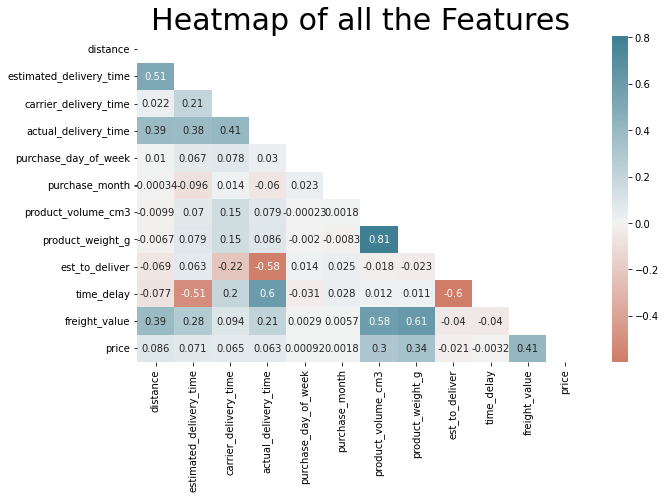

In [19]:
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(merge_df[merge_df.columns[::-1]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 6))
sns.heatmap(merge_df[merge_df.columns[::-1]].corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, )
plt.title("Heatmap of all the Features", fontsize = 30)
#plt.yticks(rotation=0)

In [21]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109659 entries, 0 to 112346
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    109659 non-null  float64
 1   freight_value            109659 non-null  float64
 2   time_delay               109659 non-null  float64
 3   est_to_deliver           109659 non-null  int32  
 4   product_weight_g         109659 non-null  float64
 5   product_volume_cm3       109659 non-null  float64
 6   purchase_month           109659 non-null  int64  
 7   purchase_day_of_week     109659 non-null  int64  
 8   actual_delivery_time     109659 non-null  float64
 9   carrier_delivery_time    109659 non-null  float64
 10  estimated_delivery_time  109659 non-null  int64  
 11  distance                 109659 non-null  float64
dtypes: float64(8), int32(1), int64(3)
memory usage: 10.5 MB


In [77]:
X = merge_df[['distance','product_weight_g', 'product_volume_cm3','purchase_month','purchase_day_of_week']]
y = merge_df['est_to_deliver']

In [47]:
merge_df

price  freight_value  time_delay  est_to_deliver customer_state  \
0        58.90          13.29        -9.0               1             RJ   
1        96.00          15.42       -12.0               1             RJ   
2        52.90          22.95       -13.0               1             RJ   
3       220.00          18.79        -9.0               1             RJ   
4        16.99          15.10       -12.0               1             RJ   
...        ...            ...         ...             ...            ...   
112341   59.00          18.51        -8.0               1             SP   
112342   22.30           8.88       -10.0               1             SP   
112343   45.00           8.72        -4.0               1             SP   
112345    7.48          15.10       -19.0               1             MG   
112346  354.90          18.92       -16.0               1             SC   

        product_weight_g  product_volume_cm3  purchase_month  \
0                  650.0              3528.0               9   
1                  900.0              5400.0               7   
2                 1200.0             15444.0               4   
3                 1100.0              4096.0              11   
4                  200.0              2052.0               5   
...                  ...                 ...             ...   
112341             500.0              5217.0               8   
112342             950.0              7350.0               5   
112343            1000.0             22000.0               8   
112345             400.0              3000.0               9   
112346             217.0              7436.0              12   

        purchase_day_of_week  actual_delivery_time  carrier_delivery_time  \
0                          2                   7.0                    6.0   
1                          0                  10.0                    2.0   
2                          1                  14.0                    1.0   
3                          4                  17.0                    4.0   
4                          1                  10.0                    1.0   
...                      ...                   ...                    ...   
112341                     3                   7.0                    4.0   
112342                     3                   8.0                    6.0   
112343                     0                  14.0                   11.0   
112345                     2                   7.0                    1.0   
112346                     2                  19.0                    0.0   

        estimated_delivery_time     distance  
0                            16   301.504681  
1                            22   776.538013  
2                            27   776.538013  
3                            26   674.644822  
4                            22   796.970628  
...                         ...          ...  
112341                       15   420.194373  
112342                       18    14.886931  
112343                       18    77.818149  
112345                       26   769.732493  
112346                       35  1500.035411  

[109659 rows x 13 columns]

In [84]:
all=merge_df.groupby(['estimated_delivery_time','customer_state'])[['distance']].mean()
all.reset_index(inplace=True)
all.sort_values('distance',ascending=False,inplace=True)

In [99]:
agrup=merge_df[merge_df.time_delay>0].groupby(['customer_state'])[['time_delay']].mean()
agrup.reset_index(inplace=True)
agrup.sort_values('time_delay', ascending=False,inplace=True)

In [104]:
agrup.reset_index(inplace=True)

In [101]:
agrup.sort_values('time_delay', ascending=False,inplace=True)

In [102]:
agrup

customer_state  time_delay
3              AP   96.333333
21             RR   36.400000
2              AM   24.400000
0              AC   18.666667
5              CE   14.695876
24             SE   14.573770
19             RN   14.543478
18             RJ   13.262676
16             PI   12.760563
13             PA   12.521008
8              GO   12.204225
4              BA   11.782910
15             PE   11.626582
22             RS   10.828169
7              ES   10.668085
12             MT   10.269841
14             PB    9.952381
9              MA    9.823944
1              AL    9.797753
23             SC    8.876877
10             MG    8.338078
25             SP    8.193422
17             PR    8.023148
11             MS    7.986111
6              DF    7.827068
26             TO    6.566667
20             RO    6.454545

In [103]:
figvolumen = px.bar(agrup.head(10), y='time_delay', x='customer_state', text_auto='.3s',
            color_discrete_sequence=["cadetblue", "red","green"])
figvolumen.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
figvolumen.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=15 # Set the font size here
        
    ))

In [86]:
all

estimated_delivery_time customer_state     distance
1139                       60             RR  3379.425930
1036                       53             RR  3346.444752
596                        36             AP  3341.686896
1143                       61             AP  3338.607866
1164                       62             RR  3324.922997
...                       ...            ...          ...
105                        14             CE     3.074075
99                         13             RN     2.989397
65                         11             MA     2.669130
7                           4             MG     2.349864
1                           3             MA     1.969575

[1302 rows x 3 columns]

In [89]:
figbubble = px.scatter(all.head(30), x='distance', y="estimated_delivery_time",
	         size="estimated_delivery_time",color='customer_state',
                  log_x=True, size_max=60, labels=dict(order_id="products sold"))
figbubble.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=15 # Set the font size here
        
    ))

In [114]:

lNorte =[ 'RO','AM','RN','PA','TO']
lCentro=['MT','DF','GO','MS']
lSur=['PR','SC','RS']
lSudeste=['MG','ES','RJ','SP']
lNordeste=['MA','PI','BA','SE','PE','PB','CE']

In [128]:
[merge_df['customer_state'].isin(lNordeste)]

[0         False
 1         False
 2         False
 3         False
 4         False
           ...  
 112341    False
 112342    False
 112343    False
 112345    False
 112346    False
 Name: customer_state, Length: 109659, dtype: bool]

In [135]:
if [merge_df.customer_state.isin(lCentro)]==True:
    merge_df['region']='Center'


In [142]:
if [merge_df.customer_state.isin(lCentro)]:
    merge_df['region']='Center'
elif [merge_df.customer_state.isin(lSur)]:
    merge_df['region']='South'
elif [merge_df.customer_state.isin(lSudeste)]:
    merge_df['region']='Southeast'
elif [merge_df.customer_state.isin(lNordeste)]:
    merge_df['region']='Northeast'

In [147]:
merge_df["region"]=merge_df.apply(lambda x: 'Center'if x["customer_state"] in lCentro else x["region"], axis=1)
merge_df["region"]=merge_df.apply(lambda x: 'South'if x["customer_state"] in lSur else x["region"], axis=1)
merge_df["region"]=merge_df.apply(lambda x: 'Southeast'if x["customer_state"] in lSudeste else x["region"], axis=1)
merge_df["region"]=merge_df.apply(lambda x: 'North'if x["customer_state"] in lNorte else x["region"], axis=1)
merge_df["region"]=merge_df.apply(lambda x: 'Northeast'if x["customer_state"] in lNordeste else x["region"], axis=1)

In [149]:
all3=merge_df.groupby(['distance','region'])[["freight_value"]].mean()
all3.reset_index(inplace=True)

In [150]:
all3.sort_values("freight_value", ascending=False, inplace=True)

In [152]:
figbubble = px.scatter(all3.head(50), x='distance', y="freight_value",
	         size="freight_value",color='region',
                  log_x=True, size_max=60, labels=dict(order_id="products sold"))
figbubble.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=15 # Set the font size here
        
    ))

In [111]:
figbubble = px.scatter(merge_df, x='product_weight_g', y="freight_value",
	         size="freight_value",color='customer_state',
                  log_x=True, size_max=60, labels=dict(order_id="products sold"))
figbubble.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=15 # Set the font size here
        
    ))